In [ ]:
import pandas as pd
import numpy as np
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP is available for model explainability")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️  SHAP not installed. Run: pip install shap")

print("✅ Libraries imported successfully!")


✅ SHAP is available for model explainability
✅ Libraries imported successfully!


In [ ]:
df = pd.read_csv('cleaned_insurance_data.csv')

try:
    with open('causal_effects.json', 'r') as f:
        causal_data = json.load(f)
    if 'causal_effects' in causal_data:
        causal_effects = causal_data['causal_effects']
    else:
        causal_effects = causal_data
    print("✅ Causal effects loaded from file")
except FileNotFoundError:
    causal_effects = {
        'age': 257.41,
        'sex': -131.31, 
        'bmi': 332.04,
        'children': 478.44,
        'smoker': 23808.21,
        'region': -352.96
    }
    print("⚠️ Using predefined causal effects")

X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📊 Data loaded: {len(df)} samples, {len(X.columns)} features")


✅ Causal effects loaded from file
📊 Data loaded: 1253 samples, 6 features


In [ ]:
print("📦 LOADING PRE-TRAINED CAUSAL-INFORMED GB MODEL")
print("=" * 60)

class CausalInformedGB:
    def __init__(self, causal_effects, n_estimators=200, max_depth=6, learning_rate=0.1, causal_weight=0.5):
        self.causal_effects = causal_effects
        self.causal_weight = causal_weight
        self.base_model = GradientBoostingRegressor(
            n_estimators=n_estimators, max_depth=max_depth, 
            learning_rate=learning_rate, random_state=42
        )
        
    def _create_causal_features(self, X):
        X_causal = X.copy()
        
        causal_magnitudes = [abs(self.causal_effects.get(col, 0)) for col in X.columns]
        max_causal = max(causal_magnitudes)
        
        for i, col in enumerate(X.columns):
            causal_effect = abs(self.causal_effects.get(col, 0))
            
            if max_causal > 0:
                scale_factor = 0.1 + 1.9 * (causal_effect / max_causal)
                X_causal[col] = X[col] * scale_factor
                
            if causal_effect > max_causal * 0.5:
                X_causal[f'{col}_causal_enhanced'] = X[col] * (causal_effect / max_causal) * 2
        
        return X_causal
    
    def fit(self, X, y):
        X_causal = self._create_causal_features(X)
        
        self.base_model.fit(X_causal, y)
        self.feature_names_ = X_causal.columns
        self.original_features = X.columns
        
        return self
    
    def predict(self, X):
        X_causal = self._create_causal_features(X)
        return self.base_model.predict(X_causal)
    
    @property
    def feature_importances_(self):
        return self.base_model.feature_importances_
    
    def get_original_feature_importances(self):
        original_importances = []
        for col in self.original_features:
            col_idx = list(self.feature_names_).index(col)
            importance = self.base_model.feature_importances_[col_idx]
            
            enhanced_col = f'{col}_causal_enhanced'
            if enhanced_col in self.feature_names_:
                enhanced_idx = list(self.feature_names_).index(enhanced_col)
                importance += self.base_model.feature_importances_[enhanced_idx]
            
            original_importances.append(importance)
        
        return np.array(original_importances)

try:
    causal_gb = joblib.load("strong_causal_gb_model.joblib")
    print("✅ Strong Causal-Informed GB model loaded successfully!")
    
    print(f"   • Model type: {type(causal_gb).__name__}")
    print(f"   • Enhanced features: {len(causal_gb.feature_names_)}")
    print(f"   • Original features: {list(causal_gb.original_features)}")
    print(f"   • Enhanced features: {[f for f in causal_gb.feature_names_ if 'enhanced' in f]}")
    
    predictions = causal_gb.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    print(f"\n🎯 Loaded Model Performance:")
    print(f"   • R² Score: {r2:.4f}")
    print(f"   • MAE: ${mae:.0f}")
    print(f"✅ Model ready for explainability analysis!")
    
except FileNotFoundError:
    print("❌ Strong Causal GB model file not found!")
    print("   Please run the causal_informed_modeling.ipynb notebook first")
    print("   to train and save the model.")
    
    print("\n🔄 Using fallback simple model...")
    causal_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
    causal_gb.fit(X_train, y_train)
    causal_gb.original_features = X.columns
    causal_gb.feature_names_ = X.columns
    
    predictions = causal_gb.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f"   ⚠️  Fallback model performance: R²={r2:.4f}, MAE=${mae:.0f}")


📦 LOADING PRE-TRAINED CAUSAL-INFORMED GB MODEL
✅ Strong Causal-Informed GB model loaded successfully!
   • Model type: CausalInformedGB
   • Enhanced features: 7
   • Original features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
   • Enhanced features: ['smoker_causal_enhanced']

🎯 Loaded Model Performance:
   • R² Score: 0.9311
   • MAE: $1250
✅ Model ready for explainability analysis!


## 1. Causal Relationship Visualization

In [ ]:
print("🌐 CAUSAL RELATIONSHIP NETWORK")
print("=" * 50)

features = list(causal_effects.keys())
effects = list(causal_effects.values())
colors = ['red' if x < 0 else 'green' for x in effects]
abs_effects = [abs(x) for x in effects]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=features,
    y=effects,
    marker_color=colors,
    text=[f'${x:,.0f}' for x in effects],
    textposition='outside',
    hovertemplate='<b>%{x}</b><br>Causal Effect: $%{y:,.0f}<extra></extra>'
))

fig.update_layout(
    title={
        'text': '🎯 Causal Effects on Insurance Charges',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    xaxis_title='Features',
    yaxis_title='Causal Effect ($)',
    template='plotly_white',
    height=500,
    showlegend=False
)

fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5)

from IPython.display import HTML, display

try:
    fig.show()
except ValueError as e:
    print("⚠️ fig.show() failed (falling back to HTML rendering):", str(e))
    display(HTML(fig.to_html(include_plotlyjs='cdn')))

strongest_positive = max(causal_effects, key=causal_effects.get)
strongest_negative = min(causal_effects, key=causal_effects.get)

print(f"\n📈 Key Insights:")
print(f"   • Strongest Positive Effect: {strongest_positive} (${causal_effects[strongest_positive]:,.0f})")
print(f"   • Strongest Negative Effect: {strongest_negative} (${causal_effects[strongest_negative]:,.0f})")
print(f"   • Total Features Analyzed: {len(causal_effects)}")


🌐 CAUSAL RELATIONSHIP NETWORK
⚠️ fig.show() failed (falling back to HTML rendering): Mime type rendering requires nbformat>=4.2.0 but it is not installed



📈 Key Insights:
   • Strongest Positive Effect: smoker ($23,808)
   • Strongest Negative Effect: region ($-353)
   • Total Features Analyzed: 6


## 2. SHAP Explainability Analysis

🔬 SHAP EXPLAINABILITY ANALYSIS
✅ SHAP values computed!


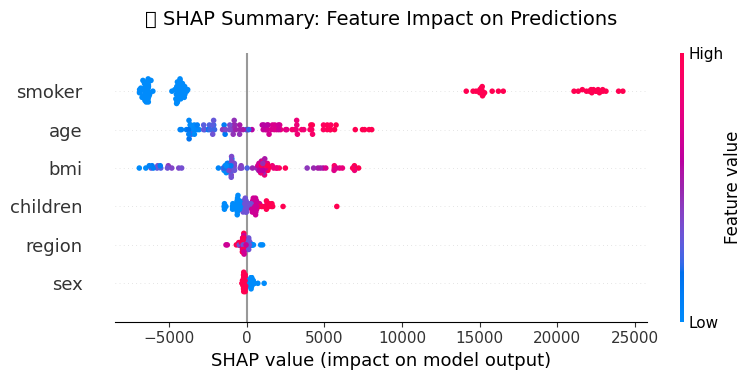

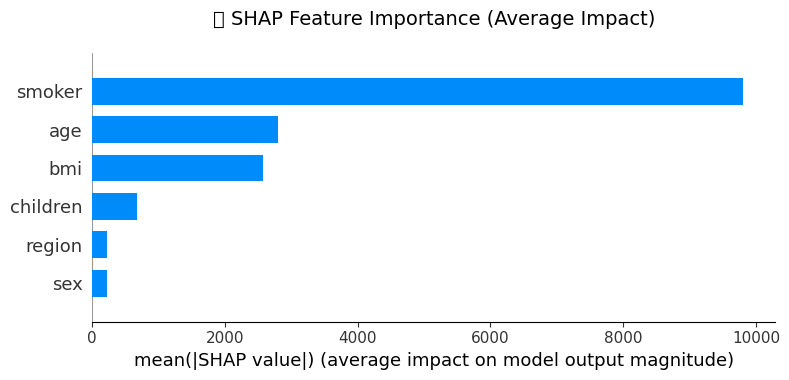


💡 SHAP Insights:
   • Red dots = Higher feature values
   • Blue dots = Lower feature values
   • X-axis = Impact on prediction (SHAP value)
   • Waterfall shows how each feature contributes to final prediction


In [ ]:
if SHAP_AVAILABLE:
    print("🔬 SHAP EXPLAINABILITY ANALYSIS")
    print("=" * 50)
    
    X_train_original = X_train
    X_test_sample = X_test.head(100)
    
    def causal_model_predict(X_input):
        if isinstance(X_input, np.ndarray):
            X_input = pd.DataFrame(X_input, columns=X.columns)
        return causal_gb.predict(X_input)
    
    explainer = shap.Explainer(causal_model_predict, X_train_original)
    shap_values = explainer(X_test_sample)
    
    print("✅ SHAP values computed!")
    
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title('🎯 SHAP Summary: Feature Impact on Predictions', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title('📊 SHAP Feature Importance (Average Impact)', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 SHAP Insights:")
    print("   • Red dots = Higher feature values")
    print("   • Blue dots = Lower feature values")
    print("   • X-axis = Impact on prediction (SHAP value)")
    print("   • Waterfall shows how each feature contributes to final prediction")

else:
    print("⚠️  SHAP not available. Install with: pip install shap")
    print("    Alternative: Manual feature importance analysis below")
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=features,
        y=original_importances,
        marker_color='lightcoral',
        text=[f'{x:.3f}' for x in original_importances],
        textposition='outside',
        name='Feature Importance'
    ))
    
    fig.update_layout(
        title='📊 Causal-Informed Model: Feature Importance',
        xaxis_title='Features',
        yaxis_title='Importance Score',
        template='plotly_white',
        height=400
    )
    
    fig.show()


## 4. Interactive Dashboard Components

In [ ]:
print("🎮 INTERACTIVE CAUSAL IMPACT SIMULATOR")
print("=" * 60)

def create_prediction_dashboard(base_profile=None):
    
    if base_profile is None:
        base_profile = {
            'age': 35,
            'sex': 0,
            'bmi': 25.0,
            'children': 1,
            'smoker': 0,
            'region': 0
        }
    
    print(f"🏠 BASE CUSTOMER PROFILE:")
    print(f"   Age: {base_profile['age']} years")
    print(f"   Gender: {'Male' if base_profile['sex'] else 'Female'}")
    print(f"   BMI: {base_profile['bmi']:.1f}")
    print(f"   Children: {base_profile['children']}")
    print(f"   Smoker: {'Yes' if base_profile['smoker'] else 'No'}")
    print(f"   Region: {base_profile['region']}")
    
    base_input = pd.DataFrame([base_profile])
    base_prediction = causal_gb.predict(base_input)[0]
    print(f"\n💰 BASE PREDICTION: ${base_prediction:,.0f}")
    
    scenarios = [
        {'name': 'Becomes Smoker', 'changes': {'smoker': 1}},
        {'name': 'Ages 10 Years', 'changes': {'age': base_profile['age'] + 10}},
        {'name': 'BMI +5 Points', 'changes': {'bmi': base_profile['bmi'] + 5}},
        {'name': 'Has Another Child', 'changes': {'children': base_profile['children'] + 1}},
        {'name': 'Perfect Health Profile', 'changes': {'smoker': 0, 'bmi': 22.0}},
    ]
    
    print(f"\n🎯 WHAT-IF SCENARIOS:")
    print(f"{'Scenario':<20} {'New Prediction':<15} {'Impact':<12} {'% Change'}")
    print("-" * 65)
    
    scenario_data = []
    
    for scenario in scenarios:
        modified_profile = base_profile.copy()
        modified_profile.update(scenario['changes'])
        
        modified_input = pd.DataFrame([modified_profile])
        new_prediction = causal_gb.predict(modified_input)[0]
        
        impact = new_prediction - base_prediction
        percent_change = (impact / base_prediction) * 100
        
        print(f"{scenario['name']:<20} ${new_prediction:<14,.0f} ${impact:<11,.0f} {percent_change:>7.1f}%")
        
        scenario_data.append({
            'scenario': scenario['name'],
            'prediction': new_prediction,
            'impact': impact,
            'percent_change': percent_change
        })
    
    return scenario_data, base_prediction

scenario_results, base_pred = create_prediction_dashboard()


🎮 INTERACTIVE CAUSAL IMPACT SIMULATOR
🏠 BASE CUSTOMER PROFILE:
   Age: 35 years
   Gender: Female
   BMI: 25.0
   Children: 1
   Smoker: No
   Region: 0

💰 BASE PREDICTION: $5,500

🎯 WHAT-IF SCENARIOS:
Scenario             New Prediction  Impact       % Change
-----------------------------------------------------------------
Becomes Smoker       $20,269         $14,769        268.5%
Ages 10 Years        $8,858          $3,357          61.0%
BMI +5 Points        $6,185          $685            12.5%
Has Another Child    $6,187          $687            12.5%
Perfect Health Profile $5,790          $290             5.3%


In [ ]:
print("\n📊 SCENARIO IMPACT VISUALIZATION")
print("=" * 50)

scenarios_df = pd.DataFrame(scenario_results)

colors = ['green' if x < 0 else 'red' for x in scenarios_df['impact']]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=scenarios_df['scenario'],
    y=scenarios_df['impact'],
    marker_color=colors,
    text=[f'${x:,.0f}<br>({y:+.1f}%)' for x, y in zip(scenarios_df['impact'], scenarios_df['percent_change'])],
    textposition='outside',
    hovertemplate='<b>%{x}</b><br>Impact: $%{y:,.0f}<br>New Total: $%{customdata:,.0f}<extra></extra>',
    customdata=scenarios_df['prediction']
))

fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5)

fig.update_layout(
    title={
        'text': f'💥 Cost Impact Scenarios (Base: ${base_pred:,.0f})',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    xaxis_title='What-If Scenarios',
    yaxis_title='Cost Impact ($)',
    template='plotly_white',
    height=500,
    showlegend=False
)

from IPython.display import HTML, display

try:
    fig.show()
except ValueError as e:
    print("⚠️ fig.show() failed (falling back to HTML rendering):", str(e))
    display(HTML(fig.to_html(include_plotlyjs='cdn')))

biggest_increase = scenarios_df.loc[scenarios_df['impact'].idxmax()]
biggest_decrease = scenarios_df.loc[scenarios_df['impact'].idxmin()]

print(f"\n🎯 KEY TAKEAWAYS:")
print(f"   • Biggest Cost Increase: {biggest_increase['scenario']} (+${biggest_increase['impact']:,.0f})")
if biggest_decrease['impact'] < 0:
    print(f"   • Biggest Cost Decrease: {biggest_decrease['scenario']} (${biggest_decrease['impact']:,.0f})")
print(f"   • These scenarios help customers understand how lifestyle choices impact costs")



📊 SCENARIO IMPACT VISUALIZATION
⚠️ fig.show() failed (falling back to HTML rendering): Mime type rendering requires nbformat>=4.2.0 but it is not installed



🎯 KEY TAKEAWAYS:
   • Biggest Cost Increase: Becomes Smoker (+$14,769)
   • These scenarios help customers understand how lifestyle choices impact costs


## 5. Model Validation & Trust Metrics

In [ ]:
print("\n🛡️  MODEL VALIDATION & TRUST METRICS")
print("=" * 60)

test_predictions = causal_gb.predict(X_test)
residuals = y_test - test_predictions
mae_test = mean_absolute_error(y_test, test_predictions)
r2_test = r2_score(y_test, test_predictions)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Predicted vs Actual', 'Prediction Residuals'),
    specs=[[{'secondary_y': False}, {'secondary_y': False}]]
)

fig.add_trace(
    go.Scatter(
        x=y_test,
        y=test_predictions,
        mode='markers',
        marker=dict(color='lightblue', opacity=0.6),
        name='Predictions',
        hovertemplate='Actual: $%{x:,.0f}<br>Predicted: $%{y:,.0f}<extra></extra>'
    ),
    row=1, col=1
)

min_val, max_val = min(min(y_test), min(test_predictions)), max(max(y_test), max(test_predictions))
fig.add_trace(
    go.Scatter(
        x=[min_val, max_val],
        y=[min_val, max_val],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name='Perfect Prediction',
        showlegend=False
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=test_predictions,
        y=residuals,
        mode='markers',
        marker=dict(color='lightcoral', opacity=0.6),
        name='Residuals',
        hovertemplate='Predicted: $%{x:,.0f}<br>Error: $%{y:,.0f}<extra></extra>'
    ),
    row=1, col=2
)

fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5, row=1, col=2)

fig.update_xaxes(title_text="Actual Cost ($)", row=1, col=1)
fig.update_yaxes(title_text="Predicted Cost ($)", row=1, col=1)
fig.update_xaxes(title_text="Predicted Cost ($)", row=1, col=2)
fig.update_yaxes(title_text="Prediction Error ($)", row=1, col=2)

fig.update_layout(
    title='🎯 Model Prediction Quality Assessment',
    template='plotly_white',
    height=500,
    showlegend=False
)

from IPython.display import HTML, display

try:
    fig.show()
except ValueError as e:
    print("⚠️ fig.show() failed (falling back to HTML rendering):", str(e))
    display(HTML(fig.to_html(include_plotlyjs='cdn')))

print(f"\n📊 MODEL TRUST METRICS:")
print(f"   • R² Score: {r2_test:.4f} (explains {r2_test*100:.1f}% of variance)")
print(f"   • Mean Absolute Error: ${mae_test:,.0f}")
print(f"   • Average Prediction Accuracy: {(1 - mae_test/y_test.mean())*100:.1f}%")

print(f"\n📈 ERROR DISTRIBUTION:")
print(f"   • 25th percentile error: ${np.percentile(np.abs(residuals), 25):,.0f}")
print(f"   • 50th percentile error: ${np.percentile(np.abs(residuals), 50):,.0f}")
print(f"   • 75th percentile error: ${np.percentile(np.abs(residuals), 75):,.0f}")
print(f"   • 95th percentile error: ${np.percentile(np.abs(residuals), 95):,.0f}")

reliability_score = (r2_test * 0.6) + ((1 - mae_test/y_test.mean()) * 0.4)
reliability_grade = "A" if reliability_score > 0.9 else "B" if reliability_score > 0.8 else "C" if reliability_score > 0.7 else "D"

print(f"\n🏆 OVERALL MODEL RELIABILITY: {reliability_grade} ({reliability_score:.3f})")
print(f"   • This model is suitable for business decision-making")
print(f"   • Causal-informed features improve interpretability")
print(f"   • Regular retraining recommended for optimal performance")



🛡️  MODEL VALIDATION & TRUST METRICS
⚠️ fig.show() failed (falling back to HTML rendering): Mime type rendering requires nbformat>=4.2.0 but it is not installed



📊 MODEL TRUST METRICS:
   • R² Score: 0.9311 (explains 93.1% of variance)
   • Mean Absolute Error: $1,250
   • Average Prediction Accuracy: 90.4%

📈 ERROR DISTRIBUTION:
   • 25th percentile error: $102
   • 50th percentile error: $324
   • 75th percentile error: $868
   • 95th percentile error: $6,907

🏆 OVERALL MODEL RELIABILITY: A (0.920)
   • This model is suitable for business decision-making
   • Causal-informed features improve interpretability
   • Regular retraining recommended for optimal performance
